In [1]:
from time import time
from tqdm import tqdm 
import site
import sys
import pandas as pd 
import numpy as np
import ast 
import matplotlib.pyplot as plt

site.addsitedir('Orion/')
site.addsitedir('MLPrimitives/')

from orion.benchmark import benchmark, _summarize_results_datasets
from Orion.orion.evaluation import CONTEXTUAL_METRICS as METRICS
from Orion.orion.evaluation import contextual_confusion_matrix
from functools import partial

del METRICS['accuracy']
METRICS['confusion_matrix'] = contextual_confusion_matrix
metrics = {k: partial(fun, weighted=False) for k, fun in METRICS.items()}

In [2]:
BUCKET = 'd3-ai-orion'
S3_URL = 'https://{}.s3.amazonaws.com/{}'

BENCHMARK_DATA = pd.read_csv(S3_URL.format(
    BUCKET, 'datasets.csv'), index_col=0, header=None).applymap(ast.literal_eval).to_dict()[1]

In [7]:
%%capture 

pipelines = ['mssa']
# hyperparameters = {"rank":50}

data=BENCHMARK_DATA
# data = {'YAHOOA2': list(BENCHMARK_DATA['YAHOOA2'])}
# data = {'YAHOOA2': ['synthetic_85']}

hyperparameters = {
    "YAHOOA2": {
        "mssa": {
            "orion.primitives.mssa.mSSATAD#1": {
                "rank": 50
            }
        }
    }
}

start = time()
scores = benchmark(pipelines=pipelines, datasets=data, metrics=metrics, rank='f1', hyperparameters=hyperparameters)

end = time()


In [9]:
BENCHMARK_DATA.keys()

dict_keys(['SMAP', 'MSL', 'YAHOOA1', 'YAHOOA2', 'YAHOOA3', 'YAHOOA4', 'artificialWithAnomaly', 'realAdExchange', 'realAWSCloudwatch', 'realTraffic', 'realTweets'])

In [3]:
def hyperparameter_dict_rank(benchmark_datasets, rank):
    rank_dict = {"mssa": {"orion.primitives.mssa.mSSATAD#1": {"rank": rank}}}
    
    hyperparam_dict = {}
    
    for dataset in benchmark_datasets.keys():
        hyperparam_dict[dataset] = rank_dict
        
    return hyperparam_dict
    

In [11]:
%%capture 
score_dataframes = []
summary_dataframes = []

for rank in [None] + list(range(1,10)):
    pipelines = ['mssa']
    data = BENCHMARK_DATA
    hyperparameters = hyperparameter_dict_rank(BENCHMARK_DATA, rank)
    scores = benchmark(pipelines=pipelines, datasets=data, metrics=metrics, rank='f1', hyperparameters=hyperparameters)
    scores['mssa_rank'] = rank
    score_dataframes.append(scores)
    scores['confusion_matrix'] = [str(x) for x in scores['confusion_matrix']]
    
    score_summary = _summarize_results_datasets(scores, metrics)
    score_summary['mssa_rank'] = rank
    summary_dataframes.append(score_summary)
    

In [13]:
pd.concat(score_dataframes, ignore_index=True).to_pickle("mssa_scores.pkl")
pd.concat(summary_dataframes, ignore_index=True).to_pickle("mssa_summaries.pkl")

In [14]:
df_summary = pd.read_pickle("mssa_summaries.pkl")

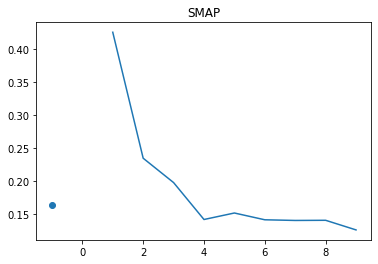

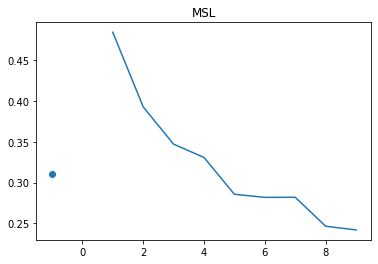

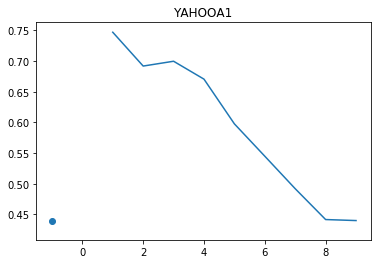

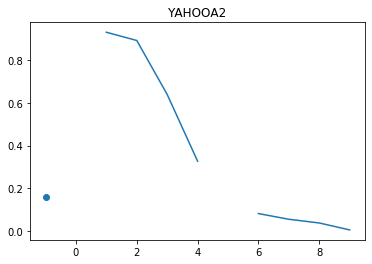

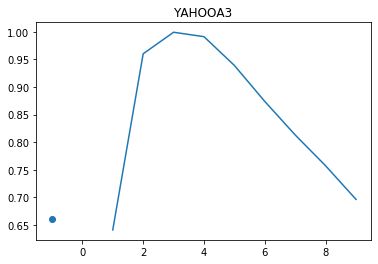

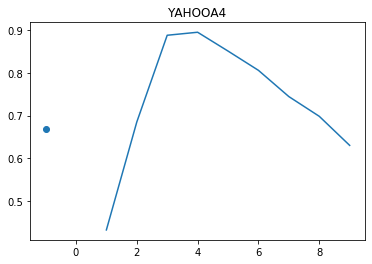

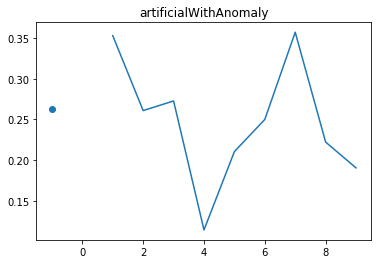

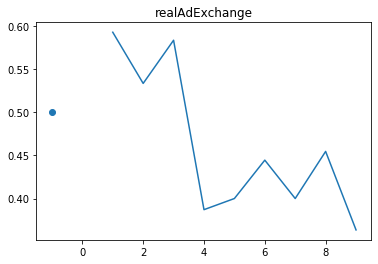

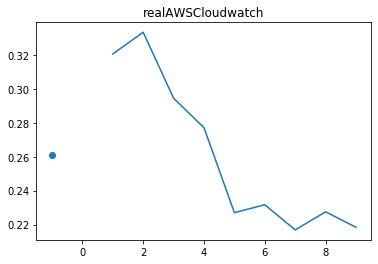

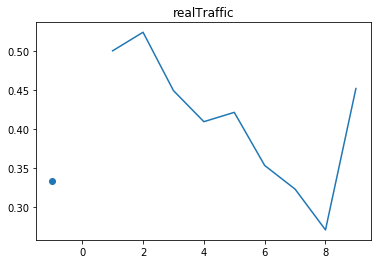

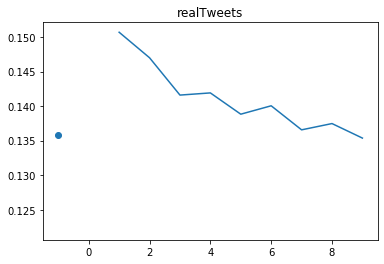

In [24]:
for dataset in BENCHMARK_DATA.keys():
    plt.figure()
    plt.scatter([-1],df_summary.query("dataset == @dataset").f1.values[0])
    plt.plot(list(range(1,10)),df_summary.query("dataset == @dataset").f1.values[1:])
    plt.title(dataset)

In [30]:
df_summary.sort_values("f1", ascending=False).drop_duplicates("dataset", keep="first")

,dataset,pipeline,fp,fn,tp,f1,mssa_rank
37,YAHOOA3,mssa,1,0,939,0.999468,3
14,YAHOOA2,mssa,4,23,177,0.929134,1
49,YAHOOA4,mssa,33,131,704,0.895674,4
13,YAHOOA1,mssa,30,54,124,0.746988,1
19,realAdExchange,mssa,8,3,8,0.592593,1
31,realTraffic,mssa,17,3,11,0.523810,2
11,MSL,mssa,36,13,23,0.484211,1
12,SMAP,mssa,70,30,37,0.425287,1
83,artificialWithAnomaly,mssa,17,1,5,0.357143,7
29,realAWSCloudwatch,mssa,105,3,27,0.333333,2


In [28]:
df_summary.sort_values("f1", ascending=False).drop_duplicates("dataset", keep="first").f1.mean()

0.5853022757613213

In [29]:
df_summary.sort_values("f1", ascending=False).drop_duplicates("dataset", keep="first").f1.std()

0.2750131668464273

In [ ]:
scores['f1_nan'] = scores['f1'].isnull()
print("Start time: {} -- End time: {} -- Elapsed: {}".format(start, end, end-start))

In [ ]:
scores.to_pickle("mssa_scores.pkl")

In [ ]:
scores.groupby("dataset")['f1_nan'].mean()

In [ ]:
type(scores['confusion_matrix'].values[0])

In [ ]:
ast.literal_eval(str(scores['confusion_matrix'].values[0]))

In [ ]:
scores

In [ ]:
scores_copy

In [5]:
scores_copy = pd.read_pickle("mssa_scores.pkl")
# scores_copy = scores,copy()

scores_copy['confusion_matrix'] = [str(x) for x in scores_copy['confusion_matrix']]
_summarize_results_datasets(scores_copy, metrics)

,dataset,pipeline,fp,fn,tp,f1
0,MSL,mssa,3,36,0,NaN
1,SMAP,mssa,29,64,3,0.060606
2,YAHOOA1,mssa,47,59,119,0.691860
3,YAHOOA2,mssa,13,29,171,0.890625
4,YAHOOA3,mssa,5,67,872,0.960352
5,YAHOOA4,mssa,71,363,472,0.685051
6,artificialWithAnomaly,mssa,14,3,3,0.260870
7,realAWSCloudwatch,mssa,105,3,27,0.333333
8,realAdExchange,mssa,11,3,8,0.533333
9,realTraffic,mssa,17,3,11,0.523810


In [4]:
scores_copy = scores.copy()

scores_copy['confusion_matrix'] = [str(x) for x in scores_copy['confusion_matrix']]
_summarize_results_datasets(scores_copy, metrics)

,dataset,pipeline,fp,fn,tp,f1
0,MSL,mssa,54,14,22,0.392857
1,SMAP,mssa,204,31,36,0.234528
2,YAHOOA1,mssa,47,59,119,0.691860
3,YAHOOA2,mssa,13,29,171,0.890625
4,YAHOOA3,mssa,5,67,872,0.960352
5,YAHOOA4,mssa,71,363,472,0.685051
6,artificialWithAnomaly,mssa,14,3,3,0.260870
7,realAWSCloudwatch,mssa,105,3,27,0.333333
8,realAdExchange,mssa,11,3,8,0.533333
9,realTraffic,mssa,17,3,11,0.523810


In [8]:
scores_copy = scores.copy()

scores_copy['confusion_matrix'] = [str(x) for x in scores_copy['confusion_matrix']]
_summarize_results_datasets(scores_copy, metrics)

,dataset,pipeline,fp,fn,tp,f1
0,MSL,mssa,54,14,22,0.392857
1,SMAP,mssa,204,31,36,0.234528
2,YAHOOA1,mssa,47,59,119,0.691860
3,YAHOOA2,mssa,100,200,0,NaN
4,YAHOOA3,mssa,5,67,872,0.960352
5,YAHOOA4,mssa,71,363,472,0.685051
6,artificialWithAnomaly,mssa,14,3,3,0.260870
7,realAWSCloudwatch,mssa,105,3,27,0.333333
8,realAdExchange,mssa,11,3,8,0.533333
9,realTraffic,mssa,17,3,11,0.523810


In [9]:
scores_copy = scores.copy()

scores_copy['confusion_matrix'] = [str(x) for x in scores_copy['confusion_matrix']]
_summarize_results_datasets(scores_copy, metrics)

,dataset,pipeline,fp,fn,tp,f1
0,MSL,mssa,36,13,23,0.484211
1,SMAP,mssa,70,30,37,0.425287
2,YAHOOA1,mssa,30,54,124,0.746988
3,YAHOOA2,mssa,4,23,177,0.929134
4,YAHOOA3,mssa,1,496,443,0.640636
5,YAHOOA4,mssa,22,599,236,0.431839
6,artificialWithAnomaly,mssa,8,3,3,0.352941
7,realAWSCloudwatch,mssa,101,5,25,0.320513
8,realAdExchange,mssa,8,3,8,0.592593
9,realTraffic,mssa,19,3,11,0.500000


In [5]:
pd.read_pickle("mssa_scores.pkl").groupby("dataset")['f1'].agg(np.nanmean)

dataset
MSL                      0.000000
SMAP                     0.065476
YAHOOA1                  0.793582
YAHOOA2                  0.943295
YAHOOA3                  0.976246
YAHOOA4                  0.691534
artificialWithAnomaly    0.622222
realAWSCloudwatch        0.438442
realAdExchange           0.616667
realTraffic              0.594444
realTweets               0.151055
Name: f1, dtype: float64

In [ ]:
scores_copy

In [ ]:
scores.groupby("dataset")['f1'].agg(np.nanmean)

In [ ]:
scores[scores['f1'].isnull()].dataset.value_counts()

In [ ]:
scores[scores['f1'].isnull()].groupby(["recall", "precision"]).count()

In [ ]:
scores[scores['f1'].isnull()].shape

In [ ]:
scores[scores['f1'].isnull()]

In [ ]:
scores[scores['recall'].isnull()]

In [ ]:
pd.read_csv("./datasets/processed/NAB_labeled/realTraffic/occupancy_6005.csv").is_anomaly.value_counts()

In [ ]:
scores

# Manual mSSA inspection 

In [7]:
from mssa.mssa import mSSA

In [26]:
df = pd.read_csv("datasets/processed/NAB_labeled/realTraffic/speed_t4013.csv")
model = mSSA(rank=50, col_to_row_ratio=1)

In [27]:
model.k

50

In [28]:
model.update_model(df.loc[:,['value']])

In [29]:
df['mssa_pred'] = model.predict("value", df.index[0], df.index[-1])['Mean Predictions']
df['error'] = np.abs(df['value'] - df['mssa_pred'])

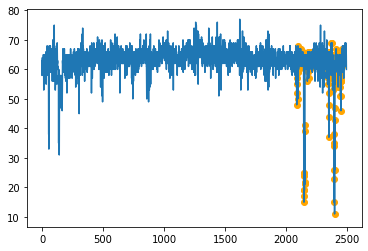

In [30]:
plt.plot(df.index, df.value)
# plt.plot(df.index, df.mssa_pred, c="green")
plt.scatter(df.query("is_anomaly == 1").index, df.query("is_anomaly == 1").value, c="orange")

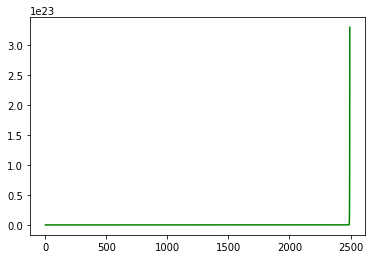

In [32]:
plt.plot(df.index, df.mssa_pred, c="green")


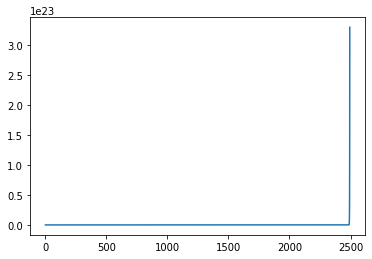

In [31]:
plt.plot(df.index, df.error)


In [25]:
scores.query("dataset == 'realTraffic'")

,pipeline,rank,f1,recall,precision,confusion_matrix,status,elapsed,split,dataset,signal
49,mssa,50,0.500000,0.5,0.500000,"(None, 1, 1, 1)",OK,0.041637,False,realTraffic,speed_t4013
107,mssa,108,0.333333,1.0,0.200000,"(None, 4, 0, 1)",OK,0.034550,False,realTraffic,TravelTime_451
139,mssa,140,0.285714,0.5,0.200000,"(None, 4, 1, 1)",OK,0.044686,False,realTraffic,occupancy_t4013
146,mssa,147,0.285714,1.0,0.166667,"(None, 5, 0, 1)",OK,0.045788,False,realTraffic,speed_6005
147,mssa,148,0.285714,1.0,0.166667,"(None, 5, 0, 1)",OK,0.037577,False,realTraffic,occupancy_6005
490,mssa,491,NaN,0.0,0.000000,"(None, 1, 4, 0)",OK,0.022570,False,realTraffic,speed_7578
491,mssa,492,NaN,0.0,0.000000,"(None, 4, 3, 0)",OK,0.049305,False,realTraffic,TravelTime_387


In [33]:
df

,timestamp,value,is_anomaly,mssa_pred,error
0,2015-09-01 11:25:00,58,0,5.799070e+01,9.300052e-03
1,2015-09-01 11:30:00,63,0,6.299250e+01,7.497852e-03
2,2015-09-01 11:35:00,63,0,6.299984e+01,1.595990e-04
3,2015-09-01 11:40:00,64,0,6.400683e+01,6.831723e-03
4,2015-09-01 11:55:00,58,0,5.800289e+01,2.886258e-03
...,...,...,...,...,...
2490,2015-09-17 15:59:00,61,0,3.207207e+21,3.207207e+21
2491,2015-09-17 16:04:00,66,0,1.021827e+22,1.021827e+22
2492,2015-09-17 16:09:00,65,0,3.255575e+22,3.255575e+22
2493,2015-09-17 16:14:00,65,0,1.037237e+23,1.037237e+23
